In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier

We will be working with the adapted Telco Customer Churn dataset. It contains 19 customer's attributes (features), the description of each of them can be found here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn. The target column 'churn' indicates whether the customer left within the last month. The goal of the project is to predict customer churn.

As the first step, let us examine the dataset.

## Examine the dataset

In [2]:
df = pd.read_csv('train_dataset.csv')
df.shape

(7043, 20)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def explore_dataset(df):
    
    features = []
    dtypes = []
    count = []
    unique = []
    nans = []
    
    for item in df.columns:
        features.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        nans.append(df[item].isna().sum())
        
    output = pd.DataFrame({
        'Feature': features, 
        'Dtype': dtypes,
        'Count': count,
        'Nr Unique': unique,
        'Nr NA': nans
    })    
        
    return output

In [5]:
explore_dataset(df)

,Feature,Dtype,Count,Nr Unique,Nr NA
0,gender,object,7043,2,0
1,SeniorCitizen,int64,7043,2,0
2,Partner,object,7043,2,0
3,Dependents,object,7043,2,0
4,tenure,int64,7043,73,0
5,PhoneService,object,7043,2,0
6,MultipleLines,object,7043,3,0
7,InternetService,object,7043,3,0
8,OnlineSecurity,object,7043,3,0
9,OnlineBackup,object,7043,3,0


Since there are 11 missing values in TotalCharges column, we will need to remove them.

In [6]:
df.dropna(axis = 0, inplace = True)

Let us check if the dataset is balanced by calculating the number if samples in each class.

In [7]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

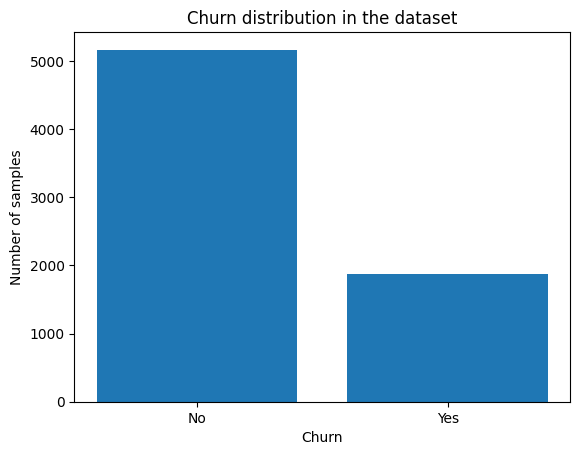

In [8]:
unique_labels, counts = np.unique(df['Churn'], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Churn')
plt.ylabel('Number of samples')
plt.title('Churn distribution in the dataset')
plt.show()

Since the samples of the class Churn rate = Yes appear ~2.76 times less frequent than samples of the class Churn rate = No, we would need to appy over-sampling technique. The easiest approach is to randomly duplicate samples in the under-represented class.

Before applying over-sampling, dataset split into random train and test subsets as well as feature preprocessing need to be done.

## Split the dataset into train and test subsets

In [9]:
seed = 42
# features X
X = df.drop('Churn', axis = 1)
# target y
y = df['Churn']
# split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)

## Feature preprocessing

Numerical features can be standardized by removing the mean and scaling to unit variance, categorical features can be encoded as a one-hot numeric array. The target column Churn contains values Yes and No and can be simply encoded with values 0 and 1 using label encoder.

In [10]:
num_columns = [4, 17, 18]
cat_columns = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
transformers = [("num", StandardScaler(), num_columns), ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_columns)]
ct = ColumnTransformer(transformers)
# fit the transformers using X_train
ct.fit(X_train)
le = LabelEncoder()
# fit label encoder
le.fit(y_train)

LabelEncoder()

Oversample the minority class.

In [11]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state = seed).fit_resample(X_train, y_train)

## Model selection and hyperparameter tuning

To predict the churn we would be using XGBoost classifier. The performance of the model heavily depends on the value of hyperparameters. In order to determine the most optimal hyperparameters, we will be applying grid search technique that exhaustively loops through a specified set of hyperparameter values.

In [12]:
# specify heperparameters grid to search over
parameters = [{
'booster': ['gbtree', 'dart'], 
'n_estimators': [50,100,150],
'max_depth': [None, 5, 10],
'random_state': [42]}]
# initialize classifier
clf = GridSearchCV(
        XGBClassifier(), parameters, scoring='balanced_accuracy', verbose = 3
    )
# 
clf.fit(ct.transform(X_train), le.transform(y_train))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END booster=gbtree, max_depth=None, n_estimators=50, random_state=42;, score=0.730 total time=   0.6s
[CV 2/5] END booster=gbtree, max_depth=None, n_estimators=50, random_state=42;, score=0.707 total time=   0.2s
[CV 3/5] END booster=gbtree, max_depth=None, n_estimators=50, random_state=42;, score=0.699 total time=   0.3s
[CV 4/5] END booster=gbtree, max_depth=None, n_estimators=50, random_state=42;, score=0.712 total time=   0.3s
[CV 5/5] END booster=gbtree, max_depth=None, n_estimators=50, random_state=42;, score=0.721 total time=   0.3s
[CV 1/5] END booster=gbtree, max_depth=None, n_estimators=100, random_state=42;, score=0.716 total time=   1.6s
[CV 2/5] END booster=gbtree, max_depth=None, n_estimators=100, random_state=42;, score=0.706 total time=   1.9s
[CV 3/5] END booster=gbtree, max_depth=None, n_estimators=100, random_state=42;, score=0.700 total time=   0.7s
[CV 4/5] END booster=gbtree, max_depth=None, n_e

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid=[{'booster': ['gbtree', 'dart'],
                          'max_depth': [None, 5, 10],
                          'n_estimators': [50, 100, 150],
                          'random_state': [42]}],
             scoring='balanced_accuracy', verbose=3)

In [13]:


pipeline = make_pipeline(ct, XGBClassifier(**clf.best_params_))
pipeline.fit(X_train_resampled, le.transform(y_train_resampled))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [4, 17, 18]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 1, 2, 3, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15,
                                                   16])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_b...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [14]:
y_pred = pipeline.predict(X_test)
balanced_accuracy_score(y_test, le.inverse_transform(y_pred))

0.7306970104131676

In [15]:
from skl2onnx import to_onnx, update_registered_converter
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from onnx import save_model

update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)


In [16]:
initial_types = []
for i, c in enumerate(df.columns[:-1]):
    if i in cat_columns:
        tensor_type = StringTensorType
    else: 
        tensor_type = FloatTensorType
    initial_types.append((c, tensor_type([None, 1])))
onx = to_onnx(pipeline, initial_types = initial_types,  options={StandardScaler: {"div": "div_cast"}})

In [17]:
save_model(onx, 'model.onnx')

# Training in one line using Falcon ML

In [1]:
from falcon import AutoML

AutoML(task = 'tabular_classification', train_data = 'train_dataset.csv', config = 'XGBOOST::OptunaLearner')

/mnt/kingston240/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extension `falcon_ml_xgboost` does not seem to be loaded. Will try to load automatically.
Attempting to load falcon_ml_xgboost...
Registered ['XGBOOST::OptunaLearner'] for task tabular_regression
Registered ['XGBOOST::OptunaLearner'] for task tabular_classification
Registered ['XGBOOST::PlainLearner'] for task tabular_regression
Registered ['XGBOOST::PlainLearner'] for task tabular_classification

Initializing a new TabularTaskManager for task `tabular_classification`
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Beginning training
Beginning the main training phase
Fitting the pipeline...


100%|██████████| 500/500 [22:17<00:00,  2.67s/it] 


Finished training

        N_SAMPLES  N_CLASSES       ACC      BACC  PRECISION    RECALL   
train       5274          2  0.771141  0.791812   0.735885  0.791812  \
eval        1758          2  0.744027  0.758063   0.708269  0.758063   

             F1  B_PRECISION  B_RECALL      B_F1     SCORE  SC_SCORE  
train  0.743797     0.825110  0.771141  0.782997  0.791812  0.791812  
eval   0.713720     0.800347  0.744027  0.757379  0.758063  0.758063   

Saving the model ...
Serializing to onnx...
	 -> Merging step 1 ::: io_map [('falcon-pl-0/transformed_column', 'falcon-pl-1/model_input')] ::: outputs: ['falcon-pl-1/output_label', 'falcon-pl-1/output_probability']
	 -> Merging step 2 ::: io_map [('falcon-pl-1/output_label', 'falcon-pl-2/encoded_labels')] ::: outputs: ['falcon-pl-2/decoded_labels']
Serialization completed.
The model was saved as `falcon_20230420.184007.onnx`
